In [133]:
import scanpy as sc
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
from scipy import sparse
import itertools as it
import anndata as ad


In [144]:
# FILE = "datasets/10XGenomics/Targeted_SC3v3_Human_Glioblastoma_Neuroscience_filtered_feature_bc_matrix.h5"
FILE = "datasets/10XGenomics/Human_PBMCs_Next_GEM_Flex_GEM-X_Flex_Comparison_count_filtered_feature_bc_matrix.h5"

In [157]:
def get_leiden(adata):
    sc.pp.calculate_qc_metrics(adata, qc_vars=[], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata.X.sum(axis = 1)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.regress_out(adata, ['total_counts'])
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_pcs = 30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution = 0.5)
    # sc.pl.umap(adata, color=['leiden'])
    return adata.obs.leiden

In [156]:
def reclassify(X, N):
    data = np.array(X[X >= 1]).flatten()
    c = Counter(data)
    # chunk = len(data) // N
    # vals = [[] for _ in range(N)]
    # i = 0
    # curr = 0
    # # for k in sorted(c):
    # #     vals[i].append(k)
    # #     curr += c[k]
    # #     if curr >= chunk:
    # #         i += 1
    # #         curr = 0
    chunk = len(c) // N + 1
    vals = [[] for _ in range(N)]
    i = 0
    curr = 0
    for k in sorted(c):
        vals[i].append(k)
        if len(vals[i]) >= chunk:
            i += 1
    for val, chunk_boundaries in enumerate(vals):
        if len(chunk_boundaries) == 0:
            continue

        l, r = chunk_boundaries[0], chunk_boundaries[-1]
        print("chunking", l, r, val + 1)
        X = np.where((l <= X) & (X <= r), val + 1, X)
    return X

In [138]:
def compare_leidens(l1, l2):
    groups1 = defaultdict(list)
    groups2 = defaultdict(list)
    for i, a in enumerate(l1):
        groups1[a].append(i)
    for i, a in enumerate(l2):
        groups2[a].append(i)
    total_matches = 0
    total = 0
    scores = {}
    for k1, v1 in groups1.items():
        subscores = {}
        for k2, v2 in groups2.items():
            s = sum(1 for i in v1 if i in v2)
            # print(s, k1, k2, len(v1), len(v2))
            subscores[k2] = (s / len(v1), s, len(v1))
            # if best_score is None or s > best_score:
            #     best_score = s 
            #     best_group = k2
        # total_matches += best_score
        # total += len(v1)
        scores[k1] = subscores
        # print(f"Best group for {k1}")
    # print(f"Overall score: {total_matches / total}")
    # print(scores)
    # st = {}
    # for k2, v2 in groups2.items():
    #     subscores = {k1: v1[k2] for k1, v1 in scores.items()}
    #     st[k2] = subscores
    taken = []
    order = sorted(list(groups1.keys()), key=lambda i: -max([j[2] for j in list(scores[i].values())]))
    for k1 in order:
        values = sorted(scores[k1].keys(), key=lambda i: -scores[k1][i][0])
        # print(values, taken)
        while values and values[0] in taken:
            values.pop(0)
        if not values or scores[k1][values[0]][0] < 0.25:
            print(f"No match for {k1}")
            total += len(groups1[k1])
        else:
            match = values[0]
            taken.append(match)
            total_matches += scores[k1][match][1]
            total += scores[k1][match][2]
            print(f"Best group for {k1}: {match}, score={scores[k1][match][0]}")
    print(f"Overall score: {total_matches / total}")
    # for k1, v1 in sorted(list(groups1.items():
        
    # return scores
    return total_matches / total


/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


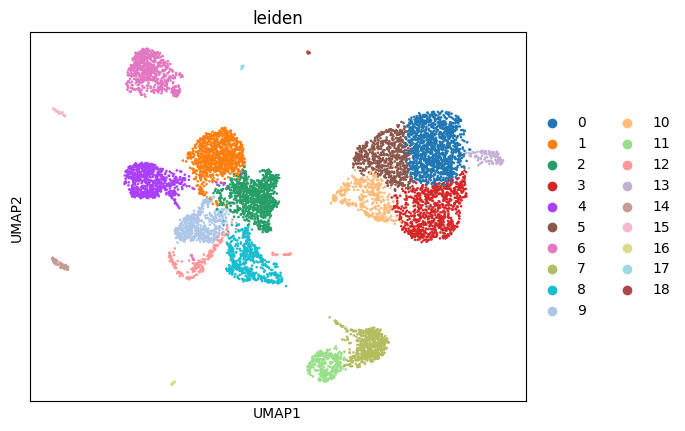

In [146]:
adata = sc.read_10x_h5(FILE)
l1 = get_leiden(adata)

In [159]:
adata = sc.read_10x_h5(FILE)
X = adata.X.todense()
X = np.array(X)
X = reclassify(X, 15)
adata2 = ad.AnnData(X)
l2 = get_leiden(adata2)
compare_leidens(l1, l2)

/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


chunking 1.0 66.0 1
chunking 67.0 132.0 2
chunking 133.0 198.0 3
chunking 199.0 264.0 4
chunking 265.0 330.0 5
chunking 331.0 396.0 6
chunking 397.0 462.0 7
chunking 463.0 528.0 8
chunking 529.0 594.0 9
chunking 595.0 661.0 10
chunking 662.0 736.0 11
chunking 737.0 817.0 12
chunking 819.0 912.0 13
chunking 913.0 1179.0 14
chunking 1209.0 16567.0 15


/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Best group for 0: 0, score=0.8625632377740303
Best group for 1: 1, score=0.9867075664621677
Best group for 2: 2, score=0.9891540130151844
Best group for 3: 3, score=0.9611178614823815
Best group for 4: 5, score=0.9839181286549707
Best group for 5: 4, score=0.9096385542168675
Best group for 6: 6, score=0.9952978056426333
Best group for 7: 7, score=0.9944029850746269
Best group for 8: 9, score=0.9844660194174757
Best group for 9: 8, score=0.9785992217898832
Best group for 10: 10, score=0.9546742209631728
Best group for 11: 11, score=0.9700374531835206
Best group for 12: 12, score=0.9791666666666666
Best group for 13: 13, score=0.9009009009009009
Best group for 14: 14, score=1.0
Best group for 15: 15, score=0.9354838709677419
Best group for 16: 16, score=1.0
Best group for 17: 17, score=1.0
Best group for 18: 18, score=1.0
Overall score: 0.9583724202626641


0.9583724202626641

In [123]:
compare_leidens(l1, l2)

No match for 0
No match for 1
No match for 2
No match for 3
No match for 4
No match for 5
No match for 6
No match for 7
No match for 8
No match for 9
No match for 10
No match for 11
No match for 12
No match for 13
No match for 14
Best group for 15: 0, score=0.25806451612903225
No match for 16
No match for 17
Best group for 18: 3, score=0.25
Overall score: 0.0012898686679174483


0.0012898686679174483

In [116]:
N = 10
adata = sc.read_10x_h5(FILE)
X = adata.X.todense()
X = np.array(X)
data = np.array(X[X >= 1]).flatten()
c = Counter(data)
chunk = len(data) // N
vals = [[] for _ in range(N)]
i = 0
curr = 0
for k in sorted(c):
    vals[i].append(k)
    curr += c[k]
    if curr >= chunk:
        i += 1
        curr = 0
for val, chunk_boundaries in enumerate(vals):
    l, r = chunk_boundaries[0], chunk_boundaries[-1]
    X = np.where((l <= X) & (X <= r), l, X)
   

/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [117]:
vals

[[1.0],
 [2.0],
 [3.0, 4.0],
 [5.0, 6.0, 7.0, 8.0],
 [9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0,
  26.0,
  27.0],
 [28.0,
  29.0,
  30.0,
  31.0,
  32.0,
  33.0,
  34.0,
  35.0,
  36.0,
  37.0,
  38.0,
  39.0,
  40.0,
  41.0,
  42.0,
  43.0,
  44.0,
  45.0,
  46.0,
  47.0,
  48.0,
  49.0,
  50.0,
  51.0,
  52.0,
  53.0,
  54.0,
  55.0,
  56.0,
  57.0,
  58.0,
  59.0,
  60.0,
  61.0,
  62.0,
  63.0,
  64.0,
  65.0,
  66.0,
  67.0,
  68.0,
  69.0,
  70.0,
  71.0,
  72.0,
  73.0,
  74.0,
  75.0,
  76.0,
  77.0,
  78.0,
  79.0,
  80.0,
  81.0,
  82.0,
  83.0,
  84.0,
  85.0,
  86.0,
  87.0,
  88.0,
  89.0,
  90.0,
  91.0,
  92.0,
  93.0,
  94.0,
  95.0,
  96.0,
  97.0,
  98.0,
  99.0,
  100.0,
  101.0,
  102.0,
  103.0,
  104.0,
  105.0,
  106.0,
  107.0,
  108.0,
  109.0,
  110.0,
  111.0,
  112.0,
  113.0,
  114.0,
  115.0,
  116.0,
  117.0,
  118.0,
  119.0,
  120.0,
  121.0,
  122.0,
  123.0,
  12